In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
device = 'cpu'

In [12]:
# get data 
batch_size = 512
epochs = 200
sample_size = 64 
nz = 128 # length of the latent vector
k = 1 

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
train_dataset = datasets.MNIST(root="/data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [13]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [15]:
# initialize G and D
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [17]:
# define optimizers for G and D
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = [] 
losses_d = [] 

In [18]:
# to save images generated by G
from torchvision.utils import save_image
images = [] 
def save_generator_image(image, path):
    save_image(image, path)

In [19]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1).to(device) #
    fake_label = torch.zeros(b_size, 1).to(device) #
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake # loss summation

In [20]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)    
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [28]:
# train G and D

from torchvision.utils import make_grid
from tqdm import tqdm

generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for idx, data in tqdm(enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        for step in range(k):                                
            data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake)
    generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()
    generated_img = make_grid(generated_img)
    if epoch in [49,99,149,199]:
        save_generator_image(generated_img, f"img/gen_img{epoch}.png")
        images.append(generated_img)
    epoch_loss_g = loss_g / idx 
    epoch_loss_d = loss_d / idx 
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    # print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:08, 14.62it/s]                         


Generator loss: 1.20791638, Discriminator loss: 1.12719262


118it [00:07, 14.93it/s]                         


Generator loss: 1.16822278, Discriminator loss: 1.14941525


118it [00:07, 14.82it/s]                         


Generator loss: 1.21145618, Discriminator loss: 1.12065375


118it [00:08, 14.75it/s]                         


Generator loss: 1.19503081, Discriminator loss: 1.13696861


118it [00:07, 14.91it/s]                         


Generator loss: 1.18525934, Discriminator loss: 1.13317907


118it [00:07, 14.92it/s]                         


Generator loss: 1.16147828, Discriminator loss: 1.14111578


118it [00:07, 14.97it/s]                         


Generator loss: 1.17267847, Discriminator loss: 1.12626088


118it [00:08, 14.65it/s]                         


Generator loss: 1.15302265, Discriminator loss: 1.14046037


118it [00:07, 14.92it/s]                         


Generator loss: 1.15759122, Discriminator loss: 1.13419330


118it [00:07, 14.92it/s]                         


Generator loss: 1.16422284, Discriminator loss: 1.13893688


118it [00:07, 15.00it/s]                         


Generator loss: 1.20640612, Discriminator loss: 1.11702740


118it [00:08, 14.74it/s]                         


Generator loss: 1.16093683, Discriminator loss: 1.14420938


118it [00:07, 14.93it/s]                         


Generator loss: 1.14675343, Discriminator loss: 1.14173746


118it [00:08, 13.57it/s]                         


Generator loss: 1.18505144, Discriminator loss: 1.13724828


118it [00:08, 13.70it/s]                         


Generator loss: 1.15541780, Discriminator loss: 1.13405442


118it [00:08, 13.68it/s]                         


Generator loss: 1.13853335, Discriminator loss: 1.14695036


118it [00:08, 13.33it/s]                         


Generator loss: 1.13042605, Discriminator loss: 1.15521491


118it [00:08, 13.26it/s]                         


Generator loss: 1.18029773, Discriminator loss: 1.16017151


118it [00:08, 13.28it/s]                         


Generator loss: 1.17113876, Discriminator loss: 1.13576734


118it [00:08, 13.53it/s]                         


Generator loss: 1.20187438, Discriminator loss: 1.13693154


118it [00:08, 13.74it/s]                         


Generator loss: 1.21413922, Discriminator loss: 1.10960305


118it [00:08, 13.14it/s]                         


Generator loss: 1.20772386, Discriminator loss: 1.13282120


118it [00:08, 13.33it/s]                         


Generator loss: 1.18474770, Discriminator loss: 1.12581968


118it [00:09, 13.05it/s]                         


Generator loss: 1.22617257, Discriminator loss: 1.12312269


118it [00:08, 13.96it/s]                         


Generator loss: 1.22158766, Discriminator loss: 1.11407590


118it [00:08, 13.98it/s]                         


Generator loss: 1.19368196, Discriminator loss: 1.12495196


118it [00:08, 13.94it/s]                         


Generator loss: 1.16929841, Discriminator loss: 1.14849854


118it [00:08, 13.69it/s]                         


Generator loss: 1.14101613, Discriminator loss: 1.14199603


118it [00:08, 13.88it/s]                         


Generator loss: 1.20097375, Discriminator loss: 1.11531031


118it [00:08, 13.82it/s]                         


Generator loss: 1.19058955, Discriminator loss: 1.13782668


118it [00:08, 14.03it/s]                         


Generator loss: 1.17951810, Discriminator loss: 1.14301693


118it [00:08, 13.94it/s]                         


Generator loss: 1.14467227, Discriminator loss: 1.14674020


118it [00:08, 13.99it/s]                         


Generator loss: 1.18004584, Discriminator loss: 1.14357913


118it [00:08, 14.10it/s]                         


Generator loss: 1.15143418, Discriminator loss: 1.16252708


118it [00:08, 13.99it/s]                         


Generator loss: 1.14759946, Discriminator loss: 1.14552045


118it [00:08, 14.09it/s]                         


Generator loss: 1.12120986, Discriminator loss: 1.16319299


118it [00:08, 14.11it/s]                         


Generator loss: 1.13844883, Discriminator loss: 1.13833463


118it [00:08, 14.08it/s]                         


Generator loss: 1.13938916, Discriminator loss: 1.15385008


118it [00:08, 13.99it/s]                         


Generator loss: 1.13493299, Discriminator loss: 1.14419985


118it [00:08, 14.12it/s]                         


Generator loss: 1.13341546, Discriminator loss: 1.15279484


118it [00:08, 14.04it/s]                         


Generator loss: 1.10728347, Discriminator loss: 1.16395354


118it [00:08, 14.04it/s]                         


Generator loss: 1.10853398, Discriminator loss: 1.17596757


118it [00:08, 14.04it/s]                         


Generator loss: 1.15202022, Discriminator loss: 1.14369190


118it [00:08, 14.04it/s]                         


Generator loss: 1.10670435, Discriminator loss: 1.16698968


118it [00:08, 14.14it/s]                         


Generator loss: 1.17212832, Discriminator loss: 1.14236259


118it [00:08, 14.04it/s]                         


Generator loss: 1.13326192, Discriminator loss: 1.17349184


118it [00:08, 14.07it/s]                         


Generator loss: 1.15060568, Discriminator loss: 1.15125394


118it [00:08, 14.04it/s]                         


Generator loss: 1.14445043, Discriminator loss: 1.14370513


118it [00:08, 14.04it/s]                         


Generator loss: 1.15689611, Discriminator loss: 1.15806901


118it [00:08, 14.02it/s]                         


Generator loss: 1.15496659, Discriminator loss: 1.14525759


118it [00:08, 13.87it/s]                         


Generator loss: 1.10124290, Discriminator loss: 1.17696893


118it [00:08, 13.69it/s]                         


Generator loss: 1.12388515, Discriminator loss: 1.16671085


118it [00:08, 13.85it/s]                         


Generator loss: 1.13010514, Discriminator loss: 1.16138673


118it [00:08, 13.74it/s]                         


Generator loss: 1.10660994, Discriminator loss: 1.16231489


118it [00:08, 13.83it/s]                         


Generator loss: 1.11259735, Discriminator loss: 1.18245077


118it [00:08, 13.28it/s]                         


Generator loss: 1.12363815, Discriminator loss: 1.16298926


118it [00:08, 13.66it/s]                         


Generator loss: 1.09152424, Discriminator loss: 1.16879845


118it [00:08, 13.36it/s]                         


Generator loss: 1.09544182, Discriminator loss: 1.18155134


118it [00:08, 13.27it/s]                         


Generator loss: 1.09714592, Discriminator loss: 1.17997921


118it [00:08, 13.74it/s]                         


Generator loss: 1.09860373, Discriminator loss: 1.17225671


118it [00:08, 13.85it/s]                         


Generator loss: 1.05854273, Discriminator loss: 1.19536829


118it [00:08, 13.98it/s]                         


Generator loss: 1.12476552, Discriminator loss: 1.16796660


118it [00:08, 13.92it/s]                         


Generator loss: 1.09735382, Discriminator loss: 1.17071497


118it [00:08, 13.83it/s]                         


Generator loss: 1.10956693, Discriminator loss: 1.15671134


118it [00:07, 14.88it/s]                         


Generator loss: 1.08253443, Discriminator loss: 1.17309761


118it [00:08, 14.62it/s]                         


Generator loss: 1.08596933, Discriminator loss: 1.17698884


118it [00:08, 14.56it/s]                         


Generator loss: 1.07682705, Discriminator loss: 1.18214750


118it [00:08, 14.59it/s]                         


Generator loss: 1.07402837, Discriminator loss: 1.19700348


118it [00:08, 13.85it/s]                         


Generator loss: 1.07148039, Discriminator loss: 1.17639291


118it [00:08, 13.88it/s]                         


Generator loss: 1.11632752, Discriminator loss: 1.18118894


118it [00:08, 13.89it/s]                         


Generator loss: 1.06496894, Discriminator loss: 1.18546307


118it [00:08, 13.78it/s]                         


Generator loss: 1.10379291, Discriminator loss: 1.16723800


118it [00:08, 13.65it/s]                         


Generator loss: 1.10560572, Discriminator loss: 1.17193592


118it [00:08, 13.82it/s]                         


Generator loss: 1.11249673, Discriminator loss: 1.18089962


118it [00:08, 13.43it/s]                         


Generator loss: 1.06687009, Discriminator loss: 1.19372773


118it [00:08, 13.42it/s]                         


Generator loss: 1.07678235, Discriminator loss: 1.18148768


118it [00:08, 13.59it/s]                         


Generator loss: 1.09483886, Discriminator loss: 1.17617559


118it [00:08, 13.73it/s]                         


Generator loss: 1.04515529, Discriminator loss: 1.20013738


118it [00:08, 13.61it/s]                         


Generator loss: 1.06119919, Discriminator loss: 1.21267378


118it [00:08, 13.50it/s]                         


Generator loss: 1.08379519, Discriminator loss: 1.18589818


118it [00:08, 13.80it/s]                         


Generator loss: 1.07980537, Discriminator loss: 1.19359303


118it [00:08, 13.76it/s]                         


Generator loss: 1.08305705, Discriminator loss: 1.18608320


118it [00:08, 13.60it/s]                         


Generator loss: 1.05721164, Discriminator loss: 1.20908725


118it [00:08, 13.81it/s]                         


Generator loss: 1.03547454, Discriminator loss: 1.20351243


118it [00:08, 13.93it/s]                         


Generator loss: 1.03490663, Discriminator loss: 1.19284701


118it [00:08, 13.96it/s]                         


Generator loss: 1.04560125, Discriminator loss: 1.19251406


118it [00:08, 13.79it/s]                         


Generator loss: 1.04243135, Discriminator loss: 1.20561349


118it [00:08, 13.84it/s]                         


Generator loss: 1.07104146, Discriminator loss: 1.17914748


118it [00:08, 13.83it/s]                         


Generator loss: 1.07757664, Discriminator loss: 1.19428015


118it [00:08, 13.80it/s]                         


Generator loss: 1.04521358, Discriminator loss: 1.21001780


118it [00:08, 13.55it/s]                         


Generator loss: 1.08098793, Discriminator loss: 1.19640791


118it [00:08, 13.47it/s]                         


Generator loss: 1.05676794, Discriminator loss: 1.19442761


118it [00:08, 13.42it/s]                         


Generator loss: 1.07067013, Discriminator loss: 1.18110073


118it [00:08, 13.40it/s]                         


Generator loss: 1.06013513, Discriminator loss: 1.21211839


118it [00:08, 13.61it/s]                         


Generator loss: 1.06875360, Discriminator loss: 1.20243466


118it [00:08, 13.86it/s]                         


Generator loss: 1.02790952, Discriminator loss: 1.20720243


118it [00:08, 13.76it/s]                         


Generator loss: 1.01617682, Discriminator loss: 1.22635853


118it [00:08, 13.65it/s]                         


Generator loss: 1.01693594, Discriminator loss: 1.21781516


118it [00:08, 13.71it/s]                         


Generator loss: 1.06449342, Discriminator loss: 1.20420694


118it [00:08, 13.85it/s]                         


Generator loss: 1.06592786, Discriminator loss: 1.19426620


118it [00:08, 13.63it/s]                         


Generator loss: 1.06072783, Discriminator loss: 1.19385087


118it [00:08, 13.77it/s]                         


Generator loss: 1.09769475, Discriminator loss: 1.18446529


118it [00:08, 13.72it/s]                         


Generator loss: 1.03344500, Discriminator loss: 1.20553696


118it [00:08, 13.78it/s]                         


Generator loss: 1.03732812, Discriminator loss: 1.21176195


118it [00:08, 13.70it/s]                         


Generator loss: 1.04998100, Discriminator loss: 1.19781816


118it [00:08, 13.49it/s]                         


Generator loss: 1.03120685, Discriminator loss: 1.21945024


118it [00:08, 13.47it/s]                         


Generator loss: 1.06267643, Discriminator loss: 1.20280981


118it [00:08, 13.52it/s]                         


Generator loss: 1.06157219, Discriminator loss: 1.21544766


118it [00:08, 13.81it/s]                         


Generator loss: 1.03121686, Discriminator loss: 1.21210921


118it [00:08, 13.93it/s]                         


Generator loss: 1.04869723, Discriminator loss: 1.21369779


118it [00:08, 13.64it/s]                         


Generator loss: 1.06771028, Discriminator loss: 1.20047951


118it [00:08, 13.86it/s]                         


Generator loss: 1.03715193, Discriminator loss: 1.20737076


118it [00:08, 13.84it/s]                         


Generator loss: 1.04809046, Discriminator loss: 1.19855416


118it [00:08, 13.79it/s]                         


Generator loss: 1.07071853, Discriminator loss: 1.20459652


118it [00:08, 13.68it/s]                         


Generator loss: 1.06369877, Discriminator loss: 1.18908560


118it [00:08, 13.77it/s]                         


Generator loss: 1.03258765, Discriminator loss: 1.20986104


118it [00:08, 13.86it/s]                         


Generator loss: 1.05165923, Discriminator loss: 1.20548677


118it [00:08, 13.60it/s]                         


Generator loss: 1.01959634, Discriminator loss: 1.22465408


118it [00:08, 13.77it/s]                         


Generator loss: 1.05567896, Discriminator loss: 1.19928575


118it [00:08, 13.94it/s]                         


Generator loss: 1.04948449, Discriminator loss: 1.20323205


118it [00:08, 13.76it/s]                         


Generator loss: 1.03202629, Discriminator loss: 1.22628975


118it [00:08, 13.58it/s]                         


Generator loss: 1.03450906, Discriminator loss: 1.21192110


118it [00:08, 13.87it/s]                         


Generator loss: 1.03940177, Discriminator loss: 1.20989060


118it [00:08, 13.87it/s]                         


Generator loss: 1.01997960, Discriminator loss: 1.22594988


118it [00:08, 13.62it/s]                         


Generator loss: 1.03148270, Discriminator loss: 1.20814180


118it [00:08, 13.81it/s]                         


Generator loss: 1.03510320, Discriminator loss: 1.21544683


118it [00:08, 13.82it/s]                         


Generator loss: 1.07360697, Discriminator loss: 1.19607782


118it [00:08, 13.63it/s]                         


Generator loss: 0.98470610, Discriminator loss: 1.23491561


118it [00:08, 13.70it/s]                         


Generator loss: 1.02688086, Discriminator loss: 1.21862519


118it [00:08, 13.83it/s]                         


Generator loss: 1.02369404, Discriminator loss: 1.22803795


118it [00:08, 13.64it/s]                         


Generator loss: 0.98880160, Discriminator loss: 1.24239421


118it [00:08, 13.82it/s]                         


Generator loss: 1.02300131, Discriminator loss: 1.22291589


118it [00:08, 13.57it/s]                         


Generator loss: 1.05259609, Discriminator loss: 1.21659696


118it [00:08, 13.67it/s]                         


Generator loss: 1.00440538, Discriminator loss: 1.22617352


118it [00:07, 15.17it/s]                         


Generator loss: 1.01996493, Discriminator loss: 1.22252250


118it [00:07, 15.46it/s]                         


Generator loss: 1.05521512, Discriminator loss: 1.21221757


118it [00:07, 15.20it/s]                         


Generator loss: 1.02527773, Discriminator loss: 1.20842814


118it [00:07, 14.76it/s]                         


Generator loss: 1.03621507, Discriminator loss: 1.22496724


118it [00:07, 15.36it/s]                         


Generator loss: 1.02402472, Discriminator loss: 1.20466828


118it [00:07, 15.57it/s]                         


Generator loss: 1.00688970, Discriminator loss: 1.22947645


118it [00:07, 15.51it/s]                         


Generator loss: 1.03694487, Discriminator loss: 1.22699976


118it [00:07, 15.52it/s]                         


Generator loss: 1.04228497, Discriminator loss: 1.21466947


118it [00:07, 14.85it/s]                         


Generator loss: 1.02955294, Discriminator loss: 1.21364307


118it [00:08, 14.17it/s]                         


Generator loss: 1.03864753, Discriminator loss: 1.22163892


118it [00:08, 14.20it/s]                         


Generator loss: 1.04388630, Discriminator loss: 1.20442188


118it [00:08, 14.00it/s]                         


Generator loss: 1.03534257, Discriminator loss: 1.21291387


118it [00:08, 14.06it/s]                         


Generator loss: 1.02166378, Discriminator loss: 1.21988142


118it [00:08, 14.09it/s]                         


Generator loss: 1.00623357, Discriminator loss: 1.23463881


118it [00:08, 14.07it/s]                         


Generator loss: 1.02727413, Discriminator loss: 1.21544600


118it [00:08, 13.50it/s]                         


Generator loss: 1.02353048, Discriminator loss: 1.20907772


118it [00:08, 13.13it/s]                         


Generator loss: 1.00044751, Discriminator loss: 1.22826087


118it [00:08, 13.37it/s]                         


Generator loss: 1.01728773, Discriminator loss: 1.21216738


118it [00:08, 13.17it/s]                         


Generator loss: 1.00145638, Discriminator loss: 1.22563708


118it [00:07, 14.92it/s]                         


Generator loss: 1.01216853, Discriminator loss: 1.23055577


118it [00:08, 14.19it/s]                         


Generator loss: 1.03797495, Discriminator loss: 1.22005093


118it [00:09, 13.09it/s]                         


Generator loss: 1.04460549, Discriminator loss: 1.20693612


118it [00:09, 13.01it/s]                         


Generator loss: 1.02660131, Discriminator loss: 1.21330833


118it [00:08, 13.25it/s]                         


Generator loss: 1.02676141, Discriminator loss: 1.22122204


118it [00:09, 13.09it/s]                         


Generator loss: 1.03427863, Discriminator loss: 1.20448804


118it [00:08, 13.19it/s]                         


Generator loss: 1.01565838, Discriminator loss: 1.21058786


118it [00:09, 13.05it/s]                         


Generator loss: 1.01403022, Discriminator loss: 1.22355878


118it [00:09, 13.04it/s]                         


Generator loss: 1.04605567, Discriminator loss: 1.21694386


118it [00:09, 12.80it/s]                         


Generator loss: 1.03357601, Discriminator loss: 1.22924483


118it [00:09, 12.73it/s]                         


Generator loss: 1.01510358, Discriminator loss: 1.21642363


118it [00:09, 12.64it/s]                         


Generator loss: 1.03457570, Discriminator loss: 1.19905901


118it [00:09, 12.80it/s]                         


Generator loss: 1.03870773, Discriminator loss: 1.21537685


118it [00:09, 12.95it/s]                         


Generator loss: 1.02083850, Discriminator loss: 1.21808994


118it [00:09, 13.09it/s]                         


Generator loss: 1.02327251, Discriminator loss: 1.21416509


118it [00:07, 14.76it/s]                         


Generator loss: 1.03197563, Discriminator loss: 1.20505726


118it [00:07, 14.92it/s]                         


Generator loss: 1.02441132, Discriminator loss: 1.21640682


118it [00:07, 14.98it/s]                         


Generator loss: 0.99796689, Discriminator loss: 1.22284830


118it [00:08, 14.74it/s]                         


Generator loss: 0.99229127, Discriminator loss: 1.23661339


118it [00:07, 14.91it/s]                         


Generator loss: 0.98763436, Discriminator loss: 1.23102927


118it [00:08, 14.08it/s]                         


Generator loss: 1.01045263, Discriminator loss: 1.24024045


118it [00:09, 13.11it/s]                         


Generator loss: 0.96844846, Discriminator loss: 1.23310983


118it [00:08, 13.20it/s]                         


Generator loss: 1.03209388, Discriminator loss: 1.22255003


118it [00:09, 13.03it/s]                         


Generator loss: 1.01354015, Discriminator loss: 1.24717462


118it [00:09, 13.02it/s]                         


Generator loss: 1.03393400, Discriminator loss: 1.22500610


118it [00:09, 12.98it/s]                         


Generator loss: 1.03035557, Discriminator loss: 1.21877527


118it [00:09, 12.85it/s]                         


Generator loss: 1.00784993, Discriminator loss: 1.22969913


118it [00:09, 12.56it/s]                         


Generator loss: 1.00336003, Discriminator loss: 1.22142696


118it [00:09, 12.77it/s]                         


Generator loss: 1.02988660, Discriminator loss: 1.21225512


118it [00:09, 12.65it/s]                         


Generator loss: 1.02404583, Discriminator loss: 1.22339153


118it [00:09, 12.97it/s]                         


Generator loss: 1.00648308, Discriminator loss: 1.23780119


118it [00:09, 12.92it/s]                         


Generator loss: 1.00713754, Discriminator loss: 1.23855996


118it [00:09, 13.02it/s]                         


Generator loss: 0.95225644, Discriminator loss: 1.25028169


118it [00:09, 12.97it/s]                         


Generator loss: 1.00084305, Discriminator loss: 1.23174942


118it [00:09, 13.00it/s]                         


Generator loss: 0.96997494, Discriminator loss: 1.25485790


118it [00:08, 13.16it/s]                         


Generator loss: 1.00623763, Discriminator loss: 1.21907222


118it [00:08, 13.16it/s]                         


Generator loss: 1.01570487, Discriminator loss: 1.22552931


118it [00:09, 12.74it/s]                         


Generator loss: 0.97636771, Discriminator loss: 1.23893571


118it [00:08, 13.23it/s]                         


Generator loss: 1.00442278, Discriminator loss: 1.24867153


118it [00:08, 13.32it/s]                         


Generator loss: 1.02851272, Discriminator loss: 1.21726704


118it [00:08, 13.69it/s]                         


Generator loss: 1.00255394, Discriminator loss: 1.22811675


118it [00:08, 14.08it/s]                         


Generator loss: 1.00901413, Discriminator loss: 1.21789813


118it [00:08, 13.41it/s]                         


Generator loss: 1.00498080, Discriminator loss: 1.24353921


118it [00:08, 14.08it/s]                         


Generator loss: 0.97564322, Discriminator loss: 1.24233723


118it [00:08, 13.58it/s]                         


Generator loss: 1.02504015, Discriminator loss: 1.21994746


118it [00:08, 13.40it/s]                         


Generator loss: 1.03297639, Discriminator loss: 1.21997058


118it [00:09, 13.06it/s]                         

Generator loss: 1.00396907, Discriminator loss: 1.23998177


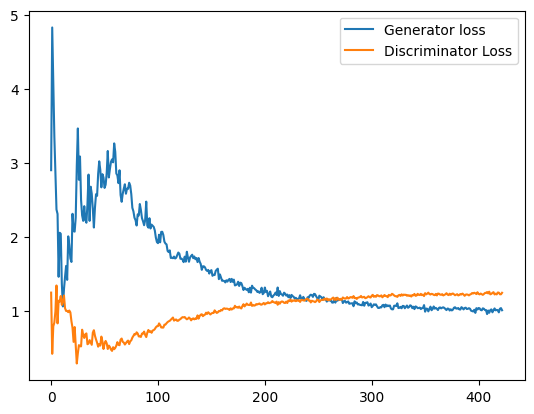

In [29]:
import matplotlib.pyplot as plt
losses_g = [fl.item() for fl in losses_g ]
losses_d = [f2.item() for f2 in losses_d ]
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.show()

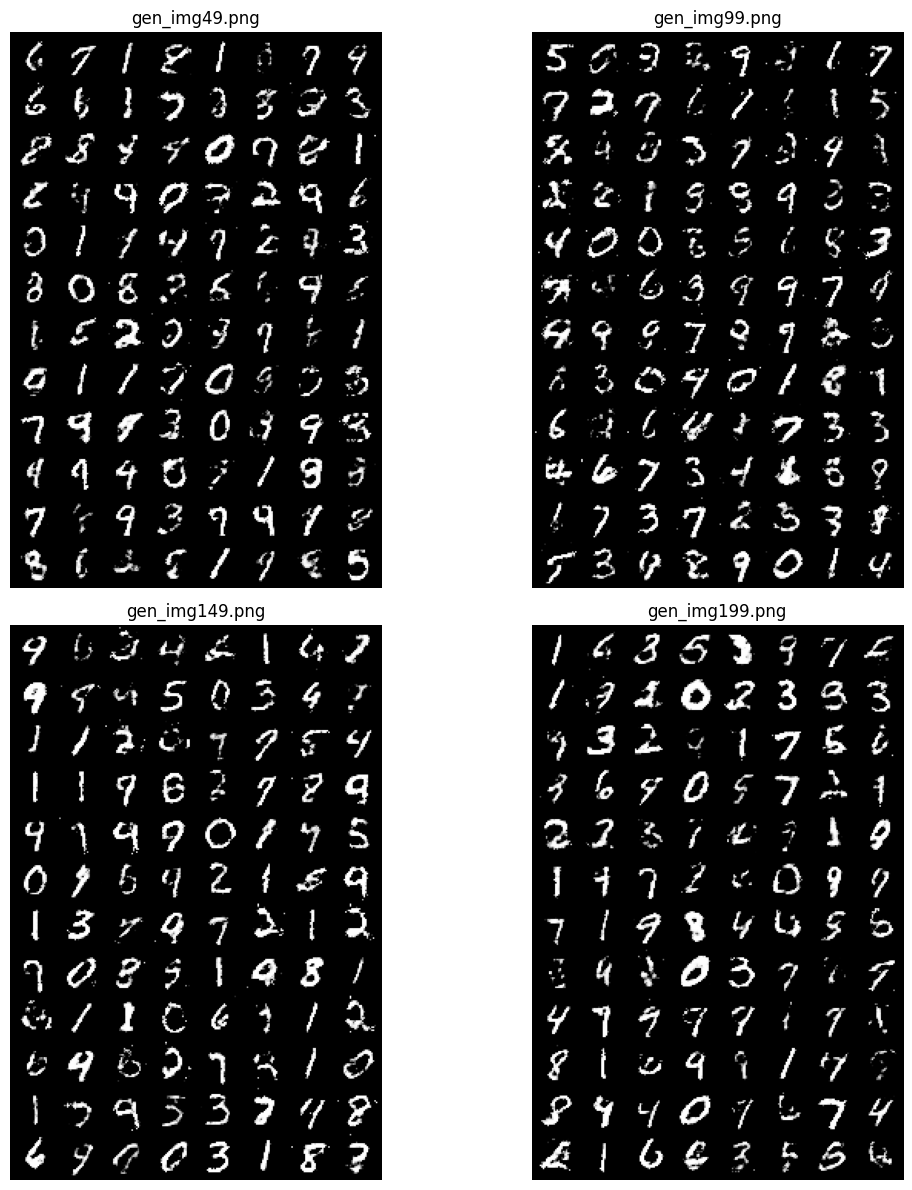

In [32]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import re

folder_path = "img/"
image_files = glob.glob(os.path.join(folder_path, "*.png"))

def extract_number(filepath):
    match = re.search(r'(\d+)', filepath)
    return int(match.group(0)) if match else 0
image_files = sorted(image_files, key=extract_number)

images = [Image.open(f) for f in image_files]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, img, name in zip(axes.flatten(), images, image_files):
    ax.imshow(img)
    ax.set_title(os.path.basename(name))
    ax.axis("off")
plt.tight_layout()
plt.show()

MLP to CNN

In [37]:
class GeneratorCNN(nn.Module):
    def __init__(self, nz):
        super().__init__()
        self.main = nn.Sequential(
            # Input: latent vector z → reshape to (nz, 1, 1)
            nn.ConvTranspose2d(nz, 256, kernel_size=7, stride=1, padding=0),  # 1x1 → 7x7
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 7x7 → 14x14
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 14x14 → 28x28
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),    # keep 28x28
            nn.Tanh()  # output in [-1,1]
        )

    def forward(self, z):
        # z: (batch_size, nz)
        z = z.view(-1, nz, 1, 1)  # reshape to 4D for ConvTranspose2d
        return self.main(z)


class DiscriminatorCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),   # 28 → 14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1), # 14 → 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1), # 7 → 3
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256*3*3, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [38]:
# initialize G and D
generator = GeneratorCNN(nz).to(device)
discriminator = DiscriminatorCNN().to(device)

# define optimizers for G and D
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = [] 
losses_d = [] 
images = [] 

In [39]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1, device=device)
    fake_label = torch.zeros(b_size, 1, device=device)

    optimizer.zero_grad()

    # Real data
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)

    # Fake data (detach so generator isn’t updated here)
    output_fake = discriminator(data_fake.detach())
    loss_fake = criterion(output_fake, fake_label)

    # Backprop both
    loss = loss_real + loss_fake
    loss.backward()
    optimizer.step()

    return loss.item()


def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size, 1, device=device)

    optimizer.zero_grad()

    output = discriminator(data_fake)
    loss = criterion(output, real_label)

    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g, loss_d = 0.0, 0.0

    for idx, (image, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
        image = image.to(device)
        b_size = image.size(0)

        # Train discriminator k times
        for step in range(k):
            noise = torch.randn(b_size, nz, device=device)
            data_fake = generator(noise).detach()
            loss_d += train_discriminator(optim_d, image, data_fake)

        # Train generator once
        noise = torch.randn(b_size, nz, device=device)
        data_fake = generator(noise)
        loss_g += train_generator(optim_g, data_fake)

    # Generate sample image
    noise = torch.randn(b_size, nz, device=device)
    generated_img = generator(noise).cpu().detach()
    generated_img = make_grid(generated_img, normalize=True)

    if epoch in [49, 99, 149, 199]:
        save_generator_image(generated_img, f"img/gen_img{epoch}.png")
        images.append(generated_img)

    # Average losses
    epoch_loss_g = loss_g / len(train_loader)
    epoch_loss_d = loss_d / len(train_loader)
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch}/{epochs} | G_loss={epoch_loss_g:.4f}, D_loss={epoch_loss_d:.4f}")


  7%|▋         | 8/118 [00:07<01:23,  1.32it/s]

GNNs

In [ ]:
from torch_geometric.nn import GCNConv

class GeneratorGNN(nn.Module):
    def __init__(self, nz, hidden_dim, out_dim):
        super(GeneratorGNN, self).__init__()
        self.fc = nn.Linear(nz, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, z, edge_index):
        # z: noise mapped to initial node features
        x = torch.relu(self.fc(z))
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.tanh(self.conv2(x, edge_index))  # node features
        return x

class DiscriminatorGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super(DiscriminatorGNN, self).__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index):
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        # Global pooling: mean over nodes
        x = torch.mean(x, dim=0)
        return torch.sigmoid(self.fc(x))
